### 0. Importing PyTorch and setting up device-agnostic code¶

In [ ]:
import torch
from torch import nn

torch.__version__

'2.1.0+cu118'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1. Get data

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


Now jpg images are in data directory
### 2. Become one with the data (data preparation)

In [ ]:
import os

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

Random image path: data/pizza_steak_sushi/test/pizza/3475871.jpg
Image class: pizza
Image height: 512
Image width: 512


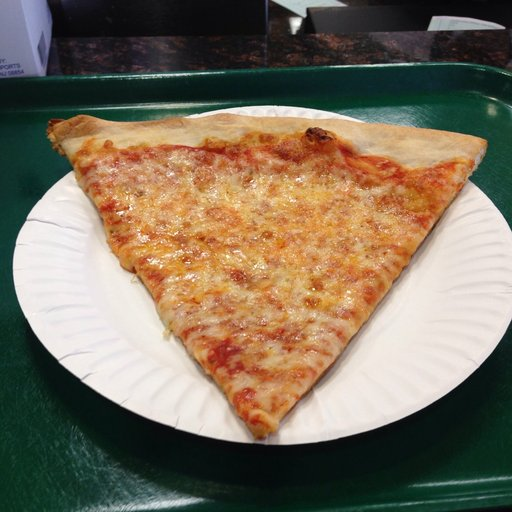

In [ ]:
import random
from PIL import Image

random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

### 3. Transforming data

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import dataloader
from torchvision import datasets, transforms

### 3.1 Transforming data with torchvision.transforms

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

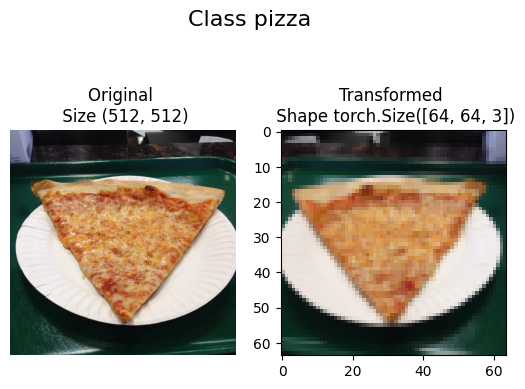

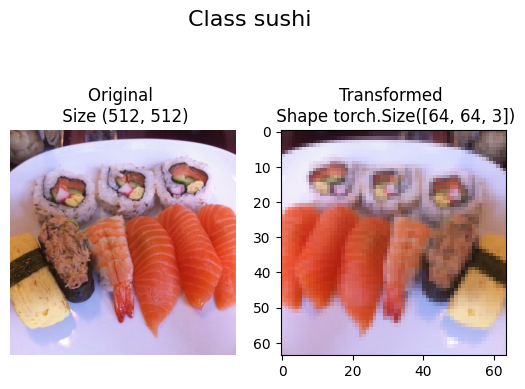

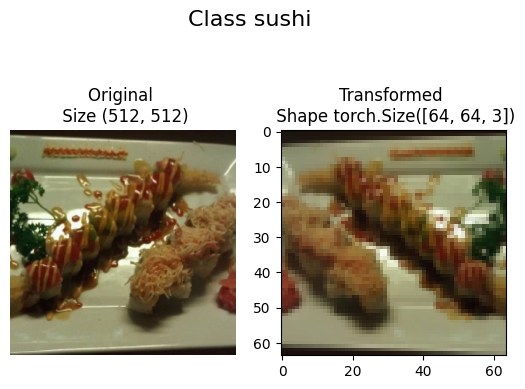

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):

  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size {f.size}")
      ax[0].axis("off")

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Shape {transformed_image.shape}")
      ax[1].axis = "off"

      fig.suptitle(f"Class {image_path.parent.stem}", fontsize = 16)

plot_transformed_images(image_path_list,
                        transform = data_transform,
                        n = 3)

### 4. Option 1: Loading Image Data Using ImageFolder

In [ ]:
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
len(train_data), len(test_data)

(225, 75)

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


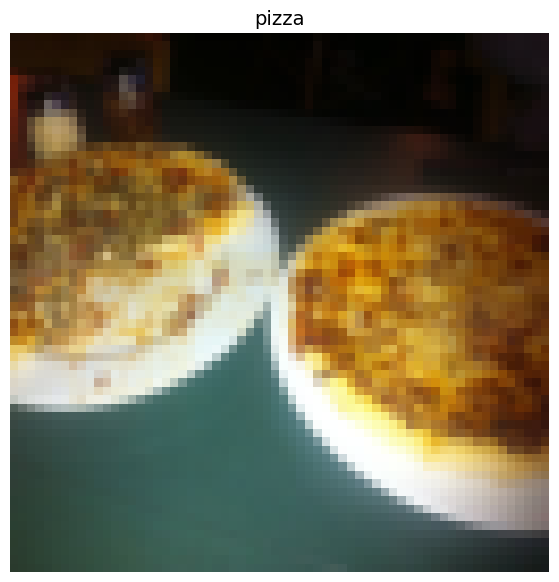

In [ ]:
img_permute = img.permute(1, 2, 0)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### 4.1 Turn loaded images into DataLoader's

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = 1,
                              num_workers = 1,
                              shuffle = True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d833590b9d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d833590bfd0>)

In [ ]:
img, label = next(iter(train_dataloader))
img.shape, label.shape, type(img), type(label)

(torch.Size([1, 3, 64, 64]), torch.Size([1]), torch.Tensor, torch.Tensor)

### 5. Option 2: Loading Image Data with a Custom Dataset

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

### 5.1 Creating a helper function to get class names

In [ ]:
target_directory = train_dir
print(f"Target directory: {target_directory}")

class_names_found = sorted( [entry.name for entry in list(os.scandir(image_path / "train"))] )
class_names_found

Target directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom Dataset to replicate ImageFolder¶

In [ ]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self, targ_dir: str, transform = None) -> None:
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7d8335aab760>,
 <__main__.ImageFolderCustom at 0x7d8335a28670>)

In [ ]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [ ]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

### 5.3 Create a function to display random images

In [ ]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = None,
                          seed: int = None):
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

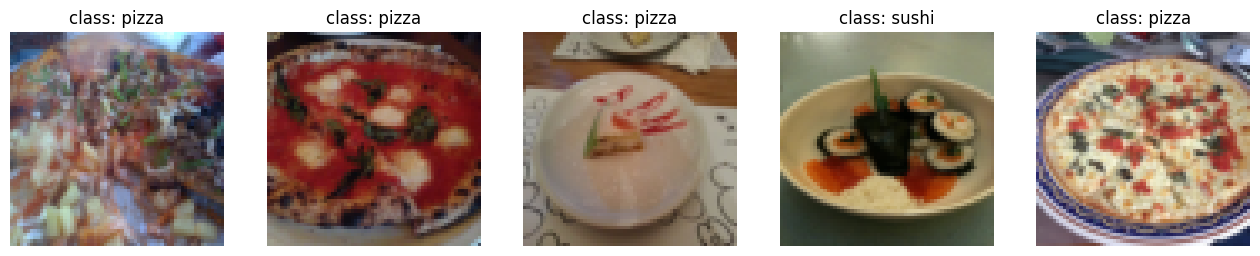

In [ ]:
display_random_images(dataset = train_data,
                      classes = train_data.classes,
                      n = 5,
                      seed = None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


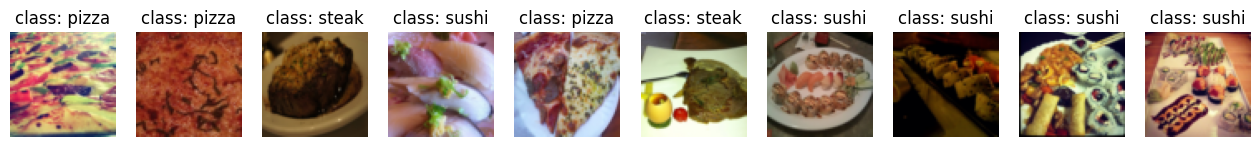

In [ ]:
display_random_images(dataset = train_data_custom,
                      classes = train_data_custom.classes,
                      n = 12,
                      seed = None)

### 5.4 Turn custom loaded images into DataLoader's

In [ ]:
from torch.utils.data import DataLoader

train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size = 1,
                                     num_workers = 0,
                                     shuffle = True)

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                    batch_size = 1,
                                    num_workers = 0,
                                    shuffle = False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7d8335283700>,
 <torch.utils.data.dataloader.DataLoader at 0x7d8335283490>)

In [ ]:
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

### 6. Other forms of transforms (data augmentation)

In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

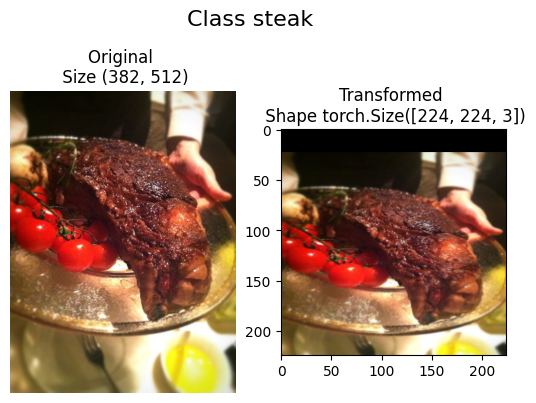

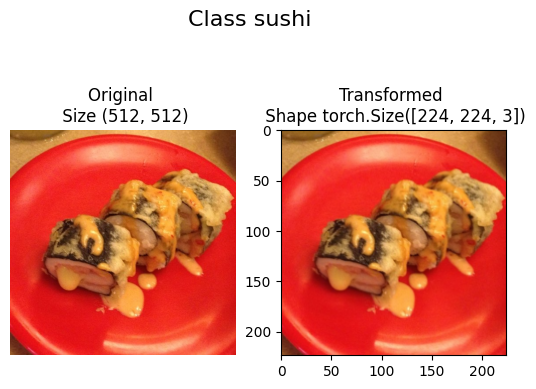

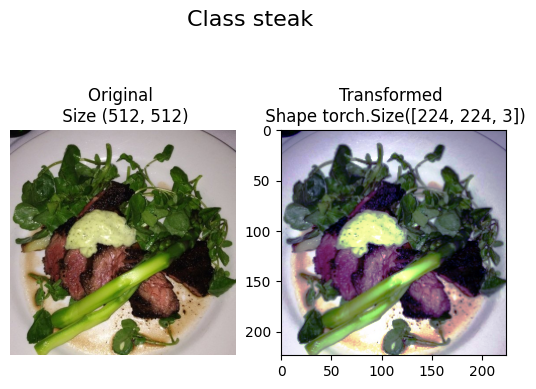

In [ ]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)


### 7. Model 0: TinyVGG without data augmentation
jpg -> Dataset -> DataLoader

In [ ]:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
from torchvision import datasets

# jpg -> Dataset
train_data_simple = datasets.ImageFolder(root = train_dir, transform = simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# Dataset -> DataLoader
import os
from torch.utils.data import DataLoader

train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size = 32,
                                     shuffle = True,
                                     num_workers = os.cpu_count())
test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size = 32,
                                    shuffle = False,
                                    num_workers = os.cpu_count())

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7d83356586d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d8335658130>)

### 7.2 Create TinyVGG model class¶

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2) # default stride value is same as kernel_size
      )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        # Where did this in_features shape come from?
        # It's because each layer of our network compresses and changes the shape of our inputs data.
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
      x = self.conv_block_1(x)
      # print(x.shape)
      x = self.conv_block_2(x)
      # print(x.shape)
      x = self.classifier(x)
      # print(x.shape)
      return x
      # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                hidden_units=10,
                output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
image_batch, label_batch = next(iter(train_dataloader_simple))

image_single = image_batch[0].unsqueeze(dim=0)
label_single = label_batch[0]

with torch.inference_mode():
  logit = model_0(image_single.to(device))

logit

tensor([[0.0578, 0.0634, 0.0351]], device='cuda:0')

In [ ]:
probs = torch.softmax(logit, dim = 1)
probs

tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

In [ ]:
pred = torch.argmax(probs, dim = 1)
pred

tensor([1], device='cuda:0')

In [ ]:
label_single

tensor(2)

### 7.4 Use torchinfo to get an idea of the shapes going through our model

In [ ]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

In [ ]:
from torchinfo import summary
summary(model_0, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train & test loop functions¶

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  test_loss, test_acc = 0, 0
  model.eval()

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      y_logit = model(X)

      loss = loss_fn(y_logit, y)
      test_loss += loss.item()

      y_pred = torch.argmax( torch.softmax(y_logit, dim = 1), dim = 1 )
      test_acc += ((y_pred == y).sum().item() / len(y_pred))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Creating a train() function to combine train_step() and test_step()

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model = model,
                                         dataloader = train_dataloader,
                                         loss_fn = loss_fn,
                                         optimizer = optimizer)

      test_loss, test_acc = test_step(model = model,
                                      dataloader = test_dataloader,
                                      loss_fn = loss_fn)

      print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

      # 5. Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results



### 7.7 Train and Evaluate Model 0

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

model_0 = TinyVGG(
    input_shape = 3,
    hidden_units = 10,
    output_shape = len(train_data.classes)
).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model = model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        loss_fn = loss_fn,
                        optimizer = optimizer,
                        epochs = NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1694 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0992 | train_acc: 0.2891 | test_loss: 1.1338 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0989 | train_acc: 0.2930 | test_loss: 1.1436 | test_acc: 0.1979
Total training time: 9.631 seconds


### 7.8 Plot the loss curves of Model 0

In [ ]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

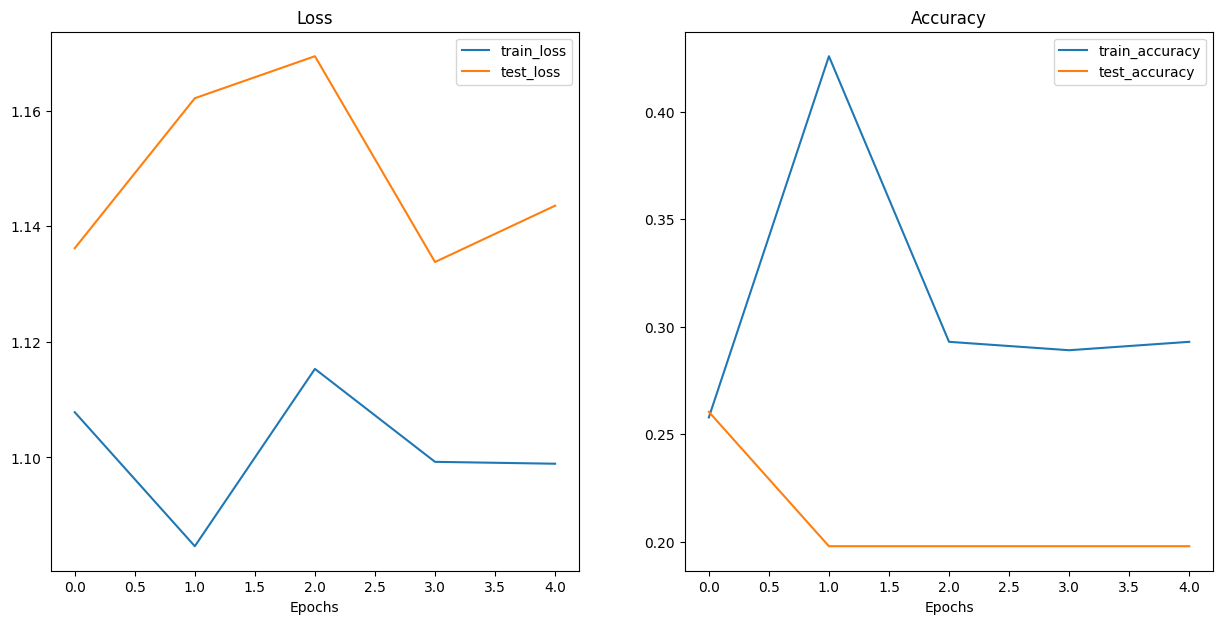

In [ ]:
plot_loss_curves(model_0_results)

### 9. Model 1: TinyVGG with Data Augmentation

In [ ]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test Dataset's and DataLoader's

In [ ]:
train_data_augmented = datasets.ImageFolder(train_dir, transform = train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform = test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [ ]:
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size = BATCH_SIZE,
                                        shuffle = True,
                                        num_workers = NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers = NUM_WORKERS)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7d82a01c6b30>,
 <torch.utils.data.dataloader.DataLoader at 0x7d82a01c7be0>)

### 9.3 Construct and train Model 1

In [ ]:
torch.manual_seed(42)

model_1 = TinyVGG(
    input_shape = 3,
    hidden_units = 10,
    output_shape = len(train_data_augmented.classes)
).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2500 | test_loss: 1.1062 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1388 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0810 | train_acc: 0.4258 | test_loss: 1.1696 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1293 | train_acc: 0.3047 | test_loss: 1.1625 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0900 | train_acc: 0.4258 | test_loss: 1.1483 | test_acc: 0.2604
Total training time: 7.515 seconds


### 9.4 Plot the loss curves of Model 1

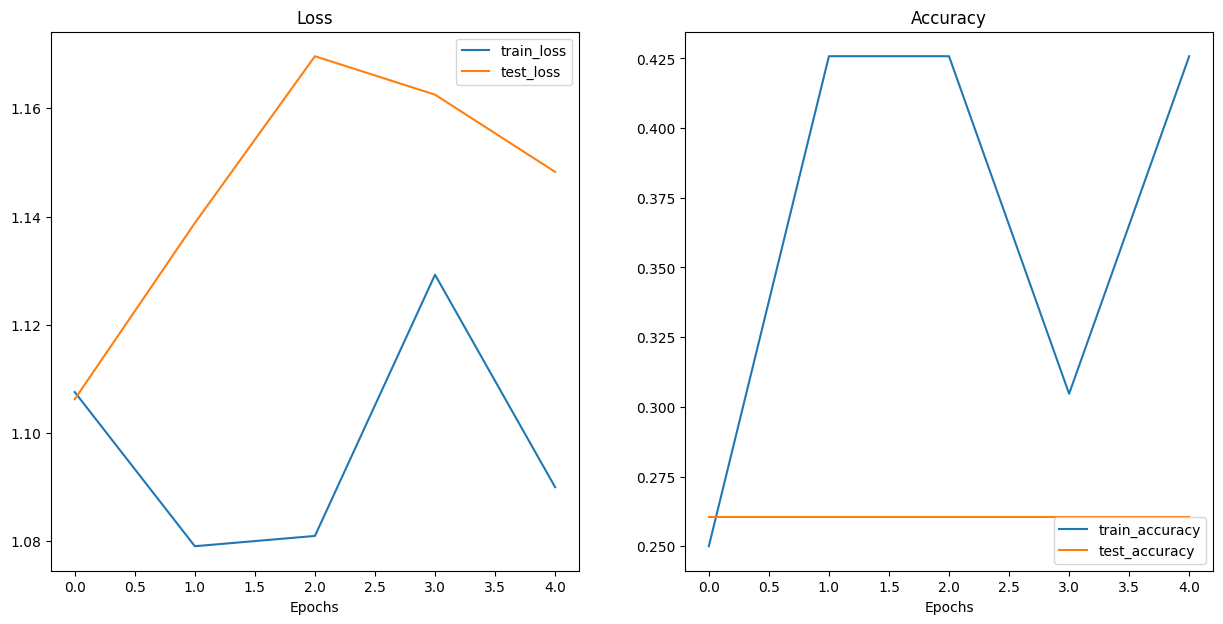

In [ ]:
plot_loss_curves(model_1_results)

### 10. Compare model results

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107836,0.257812,1.136208,0.260417
1,1.084644,0.425781,1.162167,0.197917
2,1.115328,0.292969,1.169431,0.197917
3,1.099244,0.289062,1.133821,0.197917
4,1.098920,0.292969,1.143571,0.197917


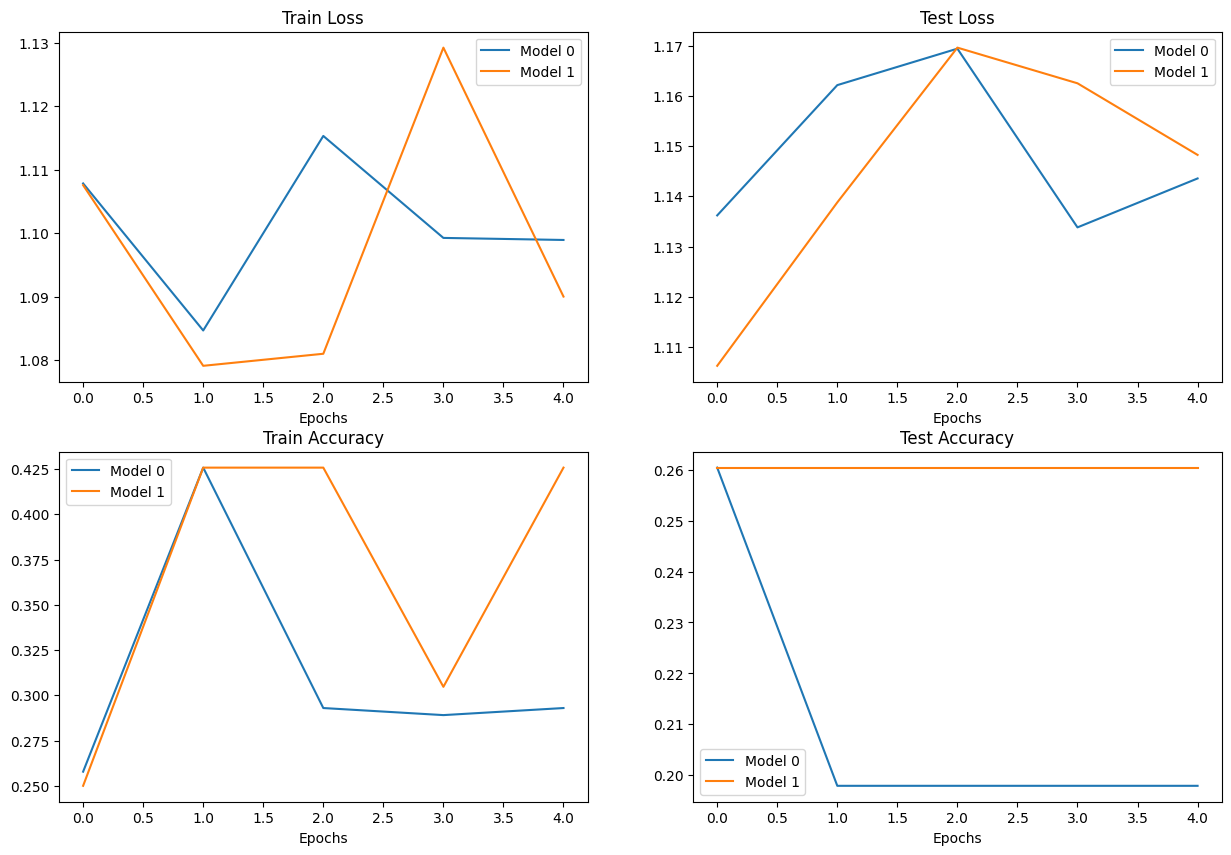

In [ ]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

### 11. Make a prediction on a custom image¶

model_0 and model_1 did not perform well

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

### 11.1 Loading in a custom image with PyTorch

In [ ]:
# .jpeg -> tensor
import torchvision

custom_image_unit8 = torchvision.io.read_image(str(custom_image_path))
custom_image_unit8, custom_image_unit8.shape

(tensor([[[154, 173, 181,  ...,  21,  18,  14],
          [146, 165, 181,  ...,  21,  18,  15],
          [124, 146, 172,  ...,  18,  17,  15],
          ...,
          [ 72,  59,  45,  ..., 152, 150, 148],
          [ 64,  55,  41,  ..., 150, 147, 144],
          [ 64,  60,  46,  ..., 149, 146, 143]],
 
         [[171, 190, 193,  ...,  22,  19,  15],
          [163, 182, 193,  ...,  22,  19,  16],
          [141, 163, 184,  ...,  19,  18,  16],
          ...,
          [ 55,  42,  28,  ..., 107, 104, 103],
          [ 47,  38,  24,  ..., 108, 104, 102],
          [ 47,  43,  29,  ..., 107, 104, 101]],
 
         [[119, 138, 147,  ...,  17,  14,  10],
          [111, 130, 145,  ...,  17,  14,  11],
          [ 87, 111, 136,  ...,  14,  13,  11],
          ...,
          [ 35,  22,   8,  ...,  52,  52,  48],
          [ 27,  18,   4,  ...,  50,  49,  44],
          [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8),
 torch.Size([3, 4032, 3024]))

In [ ]:
model_1.eval()

custom_image_unit8 = custom_image_unit8.type(torch.float32)
custom_image_unit8 = custom_image_unit8 / 255
with torch.inference_mode():
  logit = model_1(custom_image_unit8)

logit

RuntimeError: ignored

In [ ]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image /= 255.

custom_image, custom_image.shape, custom_image.dtype

(tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
          [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
          [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
          ...,
          [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
          [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
          [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],
 
         [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
          [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
          [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
          ...,
          [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
          [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
          [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],
 
         [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
          [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
          [0.3412, 0.4353, 0.5333,  ...,

### 11.2 Predicting on custom images with a trained PyTorch model

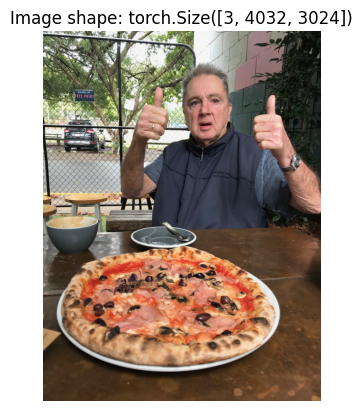

In [ ]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [ ]:
custom_image_transform = transforms.Compose([transforms.Resize((64, 64))])
custom_image_transformed = custom_image_transform(custom_image)

custom_image.shape, custom_image_transformed.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([3, 4032, 3024]), torch.Size([3, 64, 64]))

In [ ]:
model_1.eval()

with torch.inference_mode():
  logits = model_1(custom_image_transformed.unsqueeze(dim = 0).to(device)) # adding batch size dimension (NCHW format)
pred_idx = torch.argmax(torch.softmax(logits, dim = 1), dim = 1)

pred_idx

tensor([0], device='cuda:0')

In [ ]:
class_names[pred_idx]

'pizza'

In [ ]:
pred_probs = torch.softmax(logits, dim = 1)
pred_probs

tensor([[0.3713, 0.3419, 0.2868]], device='cuda:0')

### 11.3 Putting custom image prediction together: building a function

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


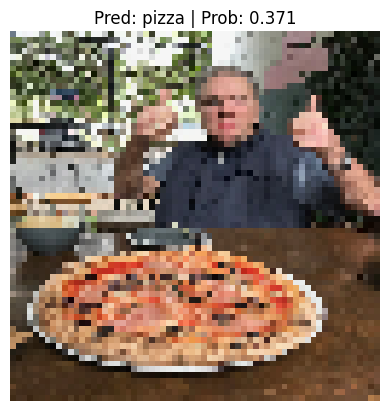

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

## Exercises

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1. How to solve underfitting
Adding more layers or hidden units:<br>
If the model is not learning patterns enough layers, this solves the underfitting<br><br>
More epochs:<br>
In case the model is not given enough opportunity to lean, we can increase the number of epochs<br><br>
Transfer learning:<br>
If a model has already working pattern in another problem, it can be used to
improve the learning process of our model

### 2. Recreate the data loading functions we built in sections 1, 2, 3 and 4. You should have train and test DataLoader's ready to use.

In [ ]:
import os
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Create data transform function
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Create train data sets
train_data = datasets.ImageFolder(root = "./data/pizza_steak_sushi/train",
                                  transform = data_transform,
                                  target_transform = None)

# Create test data sets
test_data = datasets.ImageFolder(
    root = "./data/pizza_steak_sushi/test",
    transform = data_transform
)


# Convert data sets to data loader
train_dataloader = DataLoader(train_data,
                              batch_size = 1,
                              shuffle = True,
                              num_workers = 1)


test_dataloader = DataLoader(test_data,
                              batch_size = 1,
                              shuffle = False,
                              num_workers = 1)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: ./data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: ./data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

### 3. Recreate model_0 we built in section 7.

In [ ]:
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*16*16,
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 4. Create training and testing functions for model_0

In [ ]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer):

  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Forward Pass
    y_pred = model(X)

    # Calculate Loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer Zero Grad
    optimizer.zero_grad()

    # Backward propagation on loss
    loss.backward()

    # Step optimizer
    optimizer.step()

    # Calculate Accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [ ]:
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.optim.Optimizer):
  model.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # Forward Pass
      y_pred_logits = model(X)

      # Calculate Loss
      loss = loss_fn(y_pred_logits, y)
      test_loss += loss

      # Caluculate Accuracy
      y_pred_label = y_pred_logits.argmax(dim = 1)
      test_acc += (y_pred_label == y).sum().item() / len(y_pred_label)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


### 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr = 0.001)
train_loss, train_acc = 0, 0
test_loss, test_acc = 0, 0

for epoch in range(5):
  train_loss, train_acc = train_step(model_0,
                                    dataloader = train_dataloader,
                                    loss_fn = loss_fn,
                                    optimizer = optimizer)
  test_loss, test_acc = test_step(model_0,
                                  dataloader = test_dataloader,
                                  loss_fn = loss_fn)

  print(f"Epoch {epoch} | Train Loss, Acc: {train_loss}, {train_acc} | Test Loss, Acc {test_loss}, {test_acc}")

Epoch 0 | Train Loss, Acc: 1.110326972272661, 0.29777777777777775 | Test Loss, Acc 1.0999466180801392, 0.3333333333333333
Epoch 1 | Train Loss, Acc: 1.0995252784093221, 0.3288888888888889 | Test Loss, Acc 1.1006617546081543, 0.3333333333333333
Epoch 2 | Train Loss, Acc: 1.1166696373621623, 0.3022222222222222 | Test Loss, Acc 1.0919002294540405, 0.41333333333333333
Epoch 3 | Train Loss, Acc: 1.0450752931005425, 0.5155555555555555 | Test Loss, Acc 1.0832927227020264, 0.4266666666666667
Epoch 4 | Train Loss, Acc: 0.9612368958029482, 0.5866666666666667 | Test Loss, Acc 1.0348775386810303, 0.52


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr = 0.001)
train_loss, train_acc = 0, 0
test_loss, test_acc = 0, 0

for epoch in range(20):
  train_loss, train_acc = train_step(model_1,
                                    dataloader = train_dataloader,
                                    loss_fn = loss_fn,
                                    optimizer = optimizer)
  test_loss, test_acc = test_step(model_1,
                                  dataloader = test_dataloader,
                                  loss_fn = loss_fn)

  print(f"Epoch {epoch} | Train Loss, Acc: {train_loss}, {train_acc} | Test Loss, Acc {test_loss}, {test_acc}")

Epoch 0 | Train Loss, Acc: 1.1183223128318787, 0.29777777777777775 | Test Loss, Acc 1.0970165729522705, 0.41333333333333333
Epoch 1 | Train Loss, Acc: 1.1001349258422852, 0.28444444444444444 | Test Loss, Acc 1.099375605583191, 0.25333333333333335
Epoch 2 | Train Loss, Acc: 1.0992657391230265, 0.3022222222222222 | Test Loss, Acc 1.0997196435928345, 0.3333333333333333
Epoch 3 | Train Loss, Acc: 1.0989889632331, 0.3244444444444444 | Test Loss, Acc 1.0999789237976074, 0.3333333333333333
Epoch 4 | Train Loss, Acc: 1.0989002561569214, 0.3333333333333333 | Test Loss, Acc 1.1005219221115112, 0.3333333333333333
Epoch 5 | Train Loss, Acc: 1.0990073527230158, 0.3466666666666667 | Test Loss, Acc 1.1009403467178345, 0.3333333333333333
Epoch 6 | Train Loss, Acc: 1.098608291414049, 0.3466666666666667 | Test Loss, Acc 1.1015098094940186, 0.3333333333333333
Epoch 7 | Train Loss, Acc: 1.0986422453986273, 0.3422222222222222 | Test Loss, Acc 1.101812481880188, 0.3333333333333333
Epoch 8 | Train Loss, Acc:

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr = 0.001)
train_loss, train_acc = 0, 0
test_loss, test_acc = 0, 0

for epoch in range(50):
  train_loss, train_acc = train_step(model_2,
                                    dataloader = train_dataloader,
                                    loss_fn = loss_fn,
                                    optimizer = optimizer)
  test_loss, test_acc = test_step(model_2,
                                  dataloader = test_dataloader,
                                  loss_fn = loss_fn)

  print(f"Epoch {epoch} | Train Loss, Acc: {train_loss}, {train_acc} | Test Loss, Acc {test_loss}, {test_acc}")

Epoch 0 | Train Loss, Acc: 1.118299773534139, 0.29777777777777775 | Test Loss, Acc 1.0972121953964233, 0.41333333333333333
Epoch 1 | Train Loss, Acc: 1.1005625353919135, 0.28444444444444444 | Test Loss, Acc 1.0993826389312744, 0.25333333333333335
Epoch 2 | Train Loss, Acc: 1.099181087811788, 0.3022222222222222 | Test Loss, Acc 1.0997207164764404, 0.3333333333333333
Epoch 3 | Train Loss, Acc: 1.0989838303460016, 0.3377777777777778 | Test Loss, Acc 1.0999915599822998, 0.3333333333333333
Epoch 4 | Train Loss, Acc: 1.098866229587131, 0.3377777777777778 | Test Loss, Acc 1.1004879474639893, 0.3333333333333333
Epoch 5 | Train Loss, Acc: 1.0992312876383463, 0.3466666666666667 | Test Loss, Acc 1.1009339094161987, 0.3333333333333333
Epoch 6 | Train Loss, Acc: 1.1039032165209453, 0.35555555555555557 | Test Loss, Acc 1.101167917251587, 0.3333333333333333
Epoch 7 | Train Loss, Acc: 1.0984281561109754, 0.3466666666666667 | Test Loss, Acc 1.1024961471557617, 0.3333333333333333
Epoch 8 | Train Loss, A

### 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_3 = TinyVGG(input_shape = 3,
                  hidden_units = 20,
                  output_shape = len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr = 0.001)
train_loss, train_acc = 0, 0
test_loss, test_acc = 0, 0

for epoch in range(20):
  train_loss, train_acc = train_step(model_3,
                                    dataloader = train_dataloader,
                                    loss_fn = loss_fn,
                                    optimizer = optimizer)
  test_loss, test_acc = test_step(model_3,
                                  dataloader = test_dataloader,
                                  loss_fn = loss_fn)

  print(f"Epoch {epoch} | Train Loss, Acc: {train_loss}, {train_acc} | Test Loss, Acc {test_loss}, {test_acc}")

Epoch 0 | Train Loss, Acc: 1.0962999750508202, 0.37777777777777777 | Test Loss, Acc 1.0646672248840332, 0.4
Epoch 1 | Train Loss, Acc: 1.0114047252138456, 0.5288888888888889 | Test Loss, Acc 1.0276118516921997, 0.4
Epoch 2 | Train Loss, Acc: 0.9183054175476233, 0.5822222222222222 | Test Loss, Acc 0.9787564277648926, 0.4666666666666667
Epoch 3 | Train Loss, Acc: 0.8590023467938105, 0.6222222222222222 | Test Loss, Acc 1.0259828567504883, 0.49333333333333335
Epoch 4 | Train Loss, Acc: 0.8205652448058957, 0.6177777777777778 | Test Loss, Acc 1.0281184911727905, 0.41333333333333333
Epoch 5 | Train Loss, Acc: 0.8055346225378001, 0.64 | Test Loss, Acc 0.9967285394668579, 0.4533333333333333
Epoch 6 | Train Loss, Acc: 0.7509127313126293, 0.6666666666666666 | Test Loss, Acc 1.0767742395401, 0.48
Epoch 7 | Train Loss, Acc: 0.6660777798093235, 0.7111111111111111 | Test Loss, Acc 1.1523032188415527, 0.49333333333333335
Epoch 8 | Train Loss, Acc: 0.6048542808005166, 0.7422222222222222 | Test Loss, Ac

### 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?

In [ ]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [ ]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root = "./data/pizza_steak_sushi_20_percent/train",
                                  transform = data_transform)

test_data = datasets.ImageFolder(root = "./data/pizza_steak_sushi_20_percent/test",
                                  transform = data_transform)

train_dataloader = DataLoader(train_data,
                              batch_size = 32,
                              shuffle = True,
                              num_workers = os.cpu_count())

test_dataloader = DataLoader(test_data,
                              batch_size = 32,
                              shuffle = False,
                              num_workers = os.cpu_count())

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: ./data/pizza_steak_sushi_20_percent/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: ./data/pizza_steak_sushi_20_percent/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_4 = TinyVGG(input_shape = 3,
                  hidden_units = 20,
                  output_shape = len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr = 0.001)
train_loss, train_acc = 0, 0
test_loss, test_acc = 0, 0

for epoch in range(20):
  train_loss, train_acc = train_step(model_4,
                                    dataloader = train_dataloader,
                                    loss_fn = loss_fn,
                                    optimizer = optimizer)
  test_loss, test_acc = test_step(model_4,
                                  dataloader = test_dataloader,
                                  loss_fn = loss_fn)

  print(f"Epoch {epoch} | Train Loss, Acc: {train_loss}, {train_acc} | Test Loss, Acc {test_loss}, {test_acc}")

Epoch 0 | Train Loss, Acc: 1.104146949450175, 0.33125 | Test Loss, Acc 1.1003495454788208, 0.2875
Epoch 1 | Train Loss, Acc: 1.083135430018107, 0.39166666666666666 | Test Loss, Acc 1.0686423778533936, 0.44375
Epoch 2 | Train Loss, Acc: 1.0298719167709351, 0.44166666666666665 | Test Loss, Acc 0.9559917449951172, 0.5539772727272727
Epoch 3 | Train Loss, Acc: 0.928875454266866, 0.5395833333333333 | Test Loss, Acc 0.9150047302246094, 0.5693181818181818
Epoch 4 | Train Loss, Acc: 0.8674870014190674, 0.6083333333333333 | Test Loss, Acc 0.9436306357383728, 0.47727272727272724
Epoch 5 | Train Loss, Acc: 0.8214436014493306, 0.6541666666666667 | Test Loss, Acc 1.0271822214126587, 0.49943181818181814
Epoch 6 | Train Loss, Acc: 0.8883203625679016, 0.58125 | Test Loss, Acc 0.8799204230308533, 0.584659090909091
Epoch 7 | Train Loss, Acc: 0.7724251468976339, 0.6729166666666667 | Test Loss, Acc 0.8825260400772095, 0.6039772727272728
Epoch 8 | Train Loss, Acc: 0.7676753600438436, 0.6645833333333333 | T

### 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.

In [ ]:

# Get a custom image
custom_image = "./data/my_pizza.jpeg"
with open("./data/my_pizza.jpeg", "wb") as f:
  request = requests.get("https://www.pizza-dano.co.jp/_src/77130731/img20230829095727430403.jpg?v=1699423485775")
  f.write(request.content)
# Load the image
import torchvision
img = torchvision.io.read_image(custom_image)
img

tensor([[[ 71,  69,  67,  ...,  96,  96,  96],
         [ 71,  70,  67,  ...,  96,  96,  96],
         [ 72,  70,  68,  ...,  96,  96,  96],
         ...,
         [178, 158, 127,  ...,  66,  66,  66],
         [194, 176, 148,  ...,  66,  66,  66],
         [204, 188, 163,  ...,  66,  66,  66]],

        [[ 83,  81,  79,  ..., 100, 100, 100],
         [ 83,  82,  79,  ..., 100, 100, 100],
         [ 85,  82,  80,  ..., 100, 100, 100],
         ...,
         [182, 162, 130,  ...,  65,  65,  65],
         [198, 180, 151,  ...,  65,  65,  65],
         [209, 192, 166,  ...,  65,  65,  65]],

        [[ 43,  41,  39,  ..., 109, 109, 109],
         [ 43,  42,  39,  ..., 109, 109, 109],
         [ 42,  42,  40,  ..., 109, 109, 109],
         ...,
         [106,  88,  63,  ...,  71,  71,  71],
         [121, 104,  82,  ...,  71,  71,  71],
         [129, 116,  95,  ...,  71,  71,  71]]], dtype=torch.uint8)

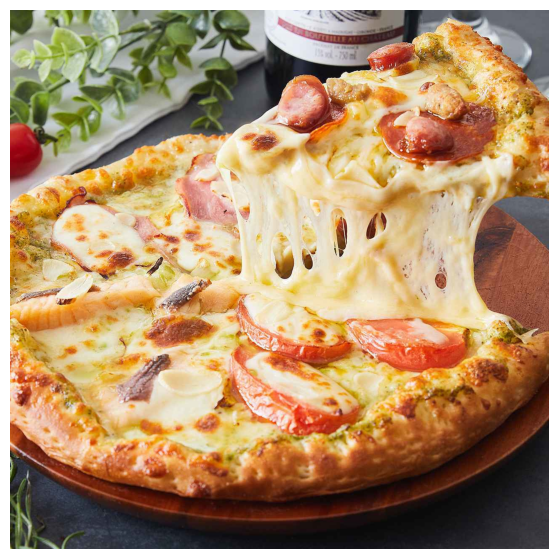

In [ ]:
import matplotlib.pyplot as plt
# View the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in HWC (height, width, color_channels) format not CHW (color_channels, height, width)
plt.axis(False);

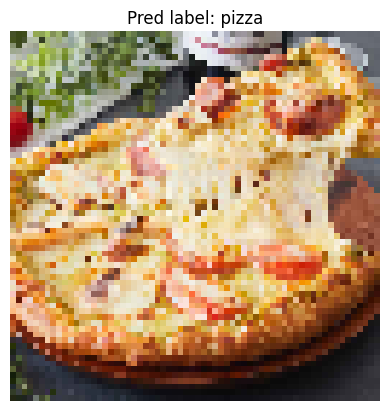

In [ ]:

model_4.eval()
with torch.inference_mode():
  img = img / 255.

  resize = transforms.Resize((64, 64))
  img = resize(img)

  batch = img.unsqueeze(0).to(device)

  y_pred_logit = model_4(batch)

  pred_label = torch.argmax(y_pred_logit, dim=1)

plt.imshow(img.permute(1, 2, 0))
plt.title(f"Pred label: {test_data.classes[pred_label]}")
plt.axis(False);

